# HW_8

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
num_classes = 10 
num_features = 784 
learning_rate = 0.01 
training_steps = 3000 
batch_size = 256 
display_step = 100 
n_hidden_1 = 256
n_hidden_2 = 512

In [16]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [17]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x, activation=1)
        x = self.layer2(x, activation=1)
        return self.out_layer(x)

In [18]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
# Функція навчання
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
        trainable_variables = neural_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [20]:
loss_history = [] 
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 10.519059, accuracy: 0.128906
step: 200, loss: 5.178601, accuracy: 0.156250
step: 300, loss: 3.419950, accuracy: 0.164062
step: 400, loss: 2.545607, accuracy: 0.171875
step: 500, loss: 2.024720, accuracy: 0.148438
step: 600, loss: 1.674947, accuracy: 0.214844
step: 700, loss: 1.449980, accuracy: 0.136719
step: 800, loss: 1.268037, accuracy: 0.121094
step: 900, loss: 1.126086, accuracy: 0.148438
step: 1000, loss: 1.003299, accuracy: 0.164062
step: 1100, loss: 0.909431, accuracy: 0.210938
step: 1200, loss: 0.838172, accuracy: 0.152344
step: 1300, loss: 0.774454, accuracy: 0.164062
step: 1400, loss: 0.715273, accuracy: 0.214844
step: 1500, loss: 0.674664, accuracy: 0.148438
step: 1600, loss: 0.628665, accuracy: 0.148438
step: 1700, loss: 0.589869, accuracy: 0.187500
step: 1800, loss: 0.559553, accuracy: 0.156250
step: 1900, loss: 0.529508, accuracy: 0.160156
step: 2000, loss: 0.502026, accuracy: 0.156250
step: 2100, loss: 0.473862, accuracy: 0.214844
step: 2200, loss: 0.4

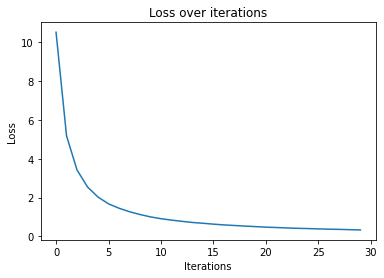

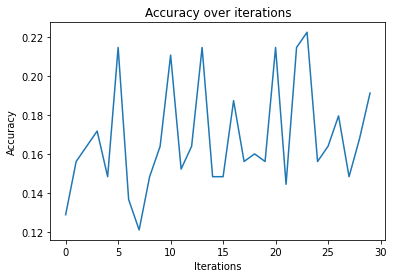

In [21]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведення графіків
plt.plot(loss_history, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy over iterations')
plt.show()

In [22]:
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
test_loss = cross_entropy(test_pred, y_test)
print("Test Accuracy: %f" % test_accuracy)
print("Test Loss: %f" % test_loss)

Test Accuracy: 0.169900
Test Loss: 13.014900


Predicted label: 3 True label: 5
Predicted label: 1 True label: 0
Predicted label: 3 True label: 6
Predicted label: 7 True label: 3
Predicted label: 3 True label: 0
Predicted label: 1 True label: 1
Predicted label: 1 True label: 2
Predicted label: 3 True label: 6
Predicted label: 1 True label: 4
Predicted label: 1 True label: 5


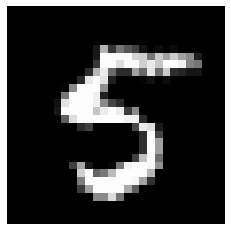

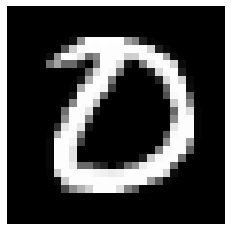

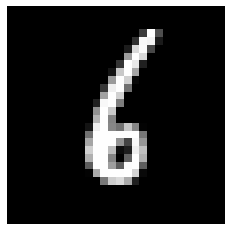

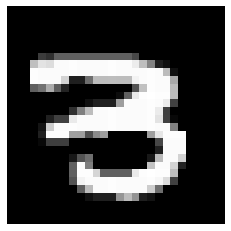

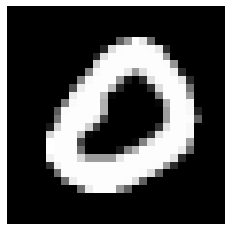

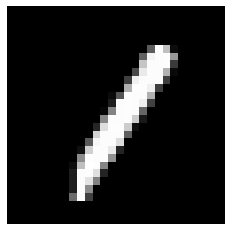

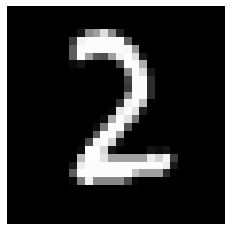

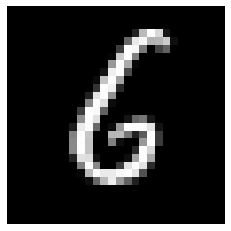

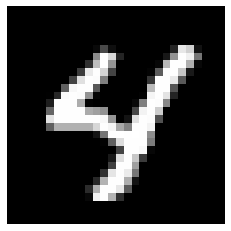

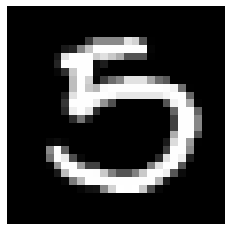

In [23]:
# Testing on 10 random images
for i in range(10):
    idx = random.randint(0, len(x_test)-1)
    image = x_test[idx].reshape((28, 28))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    pred = tf.argmax(neural_net(tf.expand_dims(x_test[idx], 0)), axis=1)
    print("Predicted label:", pred.numpy()[0], "True label:", y_test[idx])

In [24]:
'''Висновки:

1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, 
оскільки більшість передбачень вірно збігаються з фактичними мітками. 
Однак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.

2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. 
Наприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.
'''

'Висновки:\n\n1. Точність моделі: Навчена нейронна мережа демонструє досить високу точність у випадку тестових даних, \nоскільки більшість передбачень вірно збігаються з фактичними мітками. \nОднак для повноцінної оцінки потрібно провести тестування на більшому обсязі тестових даних.\n\n2. Помилки моделі: Хоча модель демонструє високу точність, вона все ще може допускати помилки у класифікації зображень. \nНаприклад, деякі зображення можуть бути класифіковані невірно через погану якість або затемнення, що ускладнює розпізнавання цифр.\n'